# atmodeller

## Tutorial 5: silicon

Import the required functionality.

In [25]:
from atmodeller import debug_logger, debug_file_logger
from atmodeller.constraints import MassConstraint, SystemConstraints, IronWustiteBufferConstraintHirschmann, FugacityConstraint, TotalPressureConstraint
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet
from atmodeller.core import GasSpecies, Species, LiquidSpecies
from atmodeller.solubilities import BasaltH2, PeridotiteH2O
from atmodeller.utilities import earth_oceans_to_kg
from atmodeller.interfaces import RealGasABC
from atmodeller.eos.saxena import get_saxena_eos_models, H2_SS92
from atmodeller.eos.holland import get_holland_eos_models, H2_CORK_HP91
from atmodeller.eos.holley import get_holley_eos_models, H2_Beattie_holley

model_holland = H2_CORK_HP91
model_holley = H2_Beattie_holley
model_saxena = H2_SS92
model1 = H2_SS92

eos_models: dict[str, RealGasABC] = get_saxena_eos_models() # get_saxena_eos_models() # get_holley_eos_models() # get_holland_eos_models()

import logging
# logger = debug_file_logger()
logger = debug_logger()
logger.setLevel(logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Define functions to setup and solve the system and store the output

In [26]:
def setup_species(
        flag_solubility: bool = False, # If True: solubility of H2 and H2O considered
        flag_nonideality: bool = False, # If True: non-ideality of H2 and H2O considered
        ) -> Species:
    if flag_solubility == False and flag_nonideality == False:
        species: Species = Species(
            [
                GasSpecies(
                    formula="H2",
                #    eos=eos_models["H2"],
                ),
                GasSpecies(
                    formula="H2O",
                #    eos=eos_models["H2O"],
                ),
                GasSpecies(
                    formula="O2",
                ),
                GasSpecies(
                    formula="OSi",
                ),
                GasSpecies(
                    formula="H4Si",
                ),
                LiquidSpecies(
                    formula="SiO2",
                ),
            ]
        )
    
    elif flag_solubility == True and flag_nonideality == False:
        species: Species = Species(
            [
                GasSpecies(
                    formula="H2",
                    solubility=BasaltH2(),
                #    eos=eos_models["H2"],
                ),
                GasSpecies(
                    formula="H2O",
                    solubility=PeridotiteH2O(),
                #    eos=eos_models["H2O"],
                ),
                GasSpecies(
                    formula="O2",
                ),
                GasSpecies(
                    formula="OSi",
                ),
                GasSpecies(
                    formula="H4Si",
                ),
                LiquidSpecies(
                    formula="SiO2",
                ),
            ]
        )

    elif flag_solubility == False and flag_nonideality == True:
        species: Species = Species(
            [
                GasSpecies(
                    formula="H2",
                    eos=eos_models["H2"],
                ),
                GasSpecies(
                    formula="H2O",
                #    eos=eos_models["H2O"],
                ),
                GasSpecies(
                    formula="O2",
                ),
                GasSpecies(
                    formula="OSi",
                ),
                GasSpecies(
                    formula="H4Si",
                ),
                LiquidSpecies(
                    formula="SiO2",
                ),
            ]
        )

    elif flag_solubility == True and flag_nonideality == True:
        species: Species = Species(
            [
                GasSpecies(
                    formula="H2",
                    solubility=BasaltH2(),
                    eos=eos_models["H2"],
                ),
                GasSpecies(
                    formula="H2O",
                    solubility=PeridotiteH2O(),
                #    eos=eos_models["H2O"],
                ),
                GasSpecies(
                    formula="O2",
                ),
                GasSpecies(
                    formula="OSi",
                ),
                GasSpecies(
                    formula="H4Si",
                ),
                LiquidSpecies(
                    formula="SiO2",
                ),
            ]
        )
    else:
        raise ValueError("Combination of flags unknown")

    return species

def setup_planet(
        surface_temperature=3400, # kelvin
        mantle_mass=11*4.208261222595111e24, # kg
        surface_radius=1.7*6371000, # metre
        ):
    return Planet(surface_temperature=surface_temperature, mantle_mass=mantle_mass, 
                  surface_radius=surface_radius)

def setup_constraints(
        flag_mass_constraint = True, # if True: MassConstraint(), else: TotalPressureConstraint()
        massH_ocean = 200, # mass of H equivalent to water oceans
        total_pressure = 100000, # bar
        logfO2_shift = 0, # deltaIW = 0 by default
        ):
    
    if flag_mass_constraint == True:
        h_kg: float = earth_oceans_to_kg(massH_ocean)
        constraint: SystemConstraints = SystemConstraints(
            [
                IronWustiteBufferConstraintHirschmann(log10_shift=logfO2_shift),
                #TotalPressureConstraint(value=total_pressure),
                MassConstraint(species="H", value=h_kg),
            ]
        )
    else:
        constraint: SystemConstraints = SystemConstraints(
            [
                IronWustiteBufferConstraintHirschmann(log10_shift=logfO2_shift),
                TotalPressureConstraint(value=total_pressure),
                #MassConstraint(species="H", value=h_kg),
            ]
        )
    return constraint

def setup_system(
        species, 
        planet,
        ):
    return InteriorAtmosphereSystem(species=species, planet=planet)

def solve_system(
        system,
        constraint,
        initial_solution: np.ndarray | None=None,
        factor=0.1,
        ):
    if initial_solution is None:
        initial_solution = np.array([100, 1000, 1e-8, 100, 10, 1000])
    system.solve(constraint, factor=factor, tol=1e-2, initial_solution=initial_solution)
    solution = system.solution_dict
    solution['total_pressure'] = system.total_pressure
    solution['log_fO2_dIW'] = np.log10(solution['O2']) \
    - IronWustiteBufferConstraintHirschmann().get_buffer_log10_value( \
        temperature=system.planet.surface_temperature, pressure=system.total_pressure)

    return solution


### 1. Compare H2 fugacity coefficients

<bound method RealGasABC.compressibility_parameter of BeattieBridgeman(critical_temperature=1, critical_pressure=1, standard_state_pressure=1, A0=2.00116875e-07, a=-5.060000000000001e-06, B0=2.096e-05, b=-4.359e-05, c=0.504)>
<bound method RealGasABC.compressibility_parameter of BeattieBridgeman(critical_temperature=1, critical_pressure=1, standard_state_pressure=1, A0=2.00116875e-07, a=-5.060000000000001e-06, B0=2.096e-05, b=-4.359e-05, c=0.504)>
<bound method RealGasABC.compressibility_parameter of BeattieBridgeman(critical_temperature=1, critical_pressure=1, standard_state_pressure=1, A0=2.00116875e-07, a=-5.060000000000001e-06, B0=2.096e-05, b=-4.359e-05, c=0.504)>
<bound method RealGasABC.compressibility_parameter of BeattieBridgeman(critical_temperature=1, critical_pressure=1, standard_state_pressure=1, A0=2.00116875e-07, a=-5.060000000000001e-06, B0=2.096e-05, b=-4.359e-05, c=0.504)>
<bound method RealGasABC.compressibility_parameter of BeattieBridgeman(critical_temperature=1, c

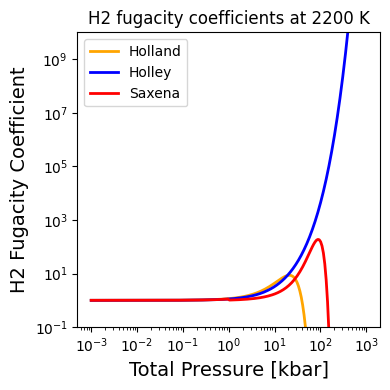

In [28]:
pressures = np.logspace(0, 6, num=200)
temperature = 2200 #k


fc_holland = []
fc_holley = []
fc_saxena = []

for pressure in pressures:
    fc_holland.append(model_holland.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_holley.append(model_holley.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_saxena.append(model_saxena.fugacity_coefficient(temperature=temperature, pressure=pressure))
    print(model_holley.compressibility_parameter)

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, fc_holland, color='orange', lw=2, label=r'Holland')
ax1.plot(pressures/1e3, fc_holley, color='blue', lw=2, label=r'Holley')
ax1.plot(pressures/1e3, fc_saxena, color='red', lw=2, label=r'Saxena')

ax1.set_title('H2 fugacity coefficients at 2200 K')

ax1.set_ylim([0.1,1e10])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'H2 Fugacity Coefficient', fontsize=14)

# ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
# ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

# ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=1, loc='upper left')
plt.savefig('H2fugcoeff_2200K.pdf', bbox_inches='tight')
plt.savefig('H2fugcoeff_2200K.png', bbox_inches='tight')
plt.show()

### 2. Problematic example

In [29]:
logger: logging.Logger = debug_file_logger()

mocean = 200
totpres = 50000
logfO2shift = 3

species = setup_species(flag_solubility = False, flag_nonideality = False)
planet = setup_planet(surface_temperature = 2200, mantle_mass = 11*4.208261222595111e24, 
                      surface_radius = 1.7*6371000)

constraint = setup_constraints(
    flag_mass_constraint = True, # if True: MassConstraint(), else: TotalPressureConstraint()
    massH_ocean = mocean, # mass of H equivalent to water oceans # Used only if prior flag is True
    total_pressure = totpres, # bar # Used only if prior flag is False
    logfO2_shift = logfO2shift, # deltaIW = 0 by default
    )

system = setup_system(species, planet)

solution = solve_system(system, constraint, factor=0.1)

logger.info("Ideal solution = %s", solution)

# Dan edits below. Get the initial condition from the solution array for the ideal gas. Below can
# be cleaned up. In general it's good to leave the solution dictionary as pristine, but since other
# data has been added we can just take the solutions for the gas species and the activity of the
# liquid

# Ideal solution, to use as the IC for the non-ideal case.
#solution['H2'] = solution['H2'] * 10
#solution['H2O'] = solution['H2O'] / 10
#solution['H4Si'] = solution['H4Si'] / 100
initial_condition = np.array([value for value in solution.values()][:6])

# Now turn on non-ideality
species = setup_species(flag_solubility = False, flag_nonideality = True)
planet = setup_planet(surface_temperature = 2200, mantle_mass = 11*4.208261222595111e24, 
                      surface_radius = 1.7*6371000)

constraint = setup_constraints(
    flag_mass_constraint = True, # if True: MassConstraint(), else: TotalPressureConstraint()
    massH_ocean = mocean, # mass of H equivalent to water oceans # Used only if prior flag is True
    total_pressure = totpres, # bar # Used only if prior flag is False
    logfO2_shift = logfO2shift, # deltaIW = 0 by default
    )

system = setup_system(species, planet)

# Pass in ideal solution as the initial condition for the real gas system
solution = solve_system(system, constraint, initial_solution=initial_condition, factor=0.1)

logger.info("Real solution = %s", solution)

[14:48:56 - atmodeller.core                - INFO     ] - Creating GasSpecies H2 using thermodynamic data in JANAF (JANAF name = H2)
[14:48:56 - atmodeller.core                - INFO     ] - Creating GasSpecies H2O using thermodynamic data in JANAF (JANAF name = H2O)
[14:48:56 - atmodeller.core                - INFO     ] - Creating GasSpecies O2 using thermodynamic data in JANAF (JANAF name = O2)
[14:48:56 - atmodeller.core                - INFO     ] - Creating GasSpecies OSi using thermodynamic data in JANAF (JANAF name = OSi)
[14:48:56 - atmodeller.core                - INFO     ] - Creating GasSpecies H4Si using thermodynamic data in JANAF (JANAF name = H4Si)
[14:48:56 - atmodeller.core                - INFO     ] - Creating LiquidSpecies SiO2 using thermodynamic data in JANAF (JANAF name = O2Si)
[14:48:56 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:48:56 - atmodeller.interior_atmosphere - INFO     ] - mantle_mass = 4.629087344854622e+25
[14:48:56 - a

### 3. H2/H2O ratio variation: H2O-H2-O2-SiO-SiH4-SiO2l system (ideal, no solubility) 

In [30]:
surface_temperature = 2200 # K
massH_ocean = 200 # earth oceans
total_pressure = 100000 # bar

species = setup_species(flag_solubility = False, flag_nonideality = False)
#planet = setup_planet(surface_temperature = 3400, mantle_mass = 1*4.208261222595111e24, 
#                      surface_radius = 1*6371000)
planet = setup_planet(surface_temperature = surface_temperature, mantle_mass = 11*4.208261222595111e24, 
                      surface_radius = 1.7*6371000)

log_fO2_dIWs = np.linspace(-8, 2, num=100) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint = setup_constraints(
        flag_mass_constraint = True, # if True: MassConstraint(), else: TotalPressureConstraint()
        massH_ocean = massH_ocean, # mass of H equivalent to water oceans
        total_pressure = total_pressure, # bar
        logfO2_shift = log_fO2_dIW, # deltaIW = 0 by default
        )
    constraints.append(constraint)

system = setup_system(species, planet)

solutions = []

for (log_fO2_dIW, constraint) in zip(log_fO2_dIWs, constraints):

    solution = solve_system(system, constraint, factor=0.1)
    fug_coeff = model1.fugacity_coefficient(temperature=surface_temperature, pressure=solution['total_pressure'])
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

[14:49:08 - atmodeller.core                - INFO     ] - Creating GasSpecies H2 using thermodynamic data in JANAF (JANAF name = H2)
[14:49:08 - atmodeller.core                - INFO     ] - Creating GasSpecies H2O using thermodynamic data in JANAF (JANAF name = H2O)
[14:49:08 - atmodeller.core                - INFO     ] - Creating GasSpecies O2 using thermodynamic data in JANAF (JANAF name = O2)
[14:49:08 - atmodeller.core                - INFO     ] - Creating GasSpecies OSi using thermodynamic data in JANAF (JANAF name = OSi)
[14:49:08 - atmodeller.core                - INFO     ] - Creating GasSpecies H4Si using thermodynamic data in JANAF (JANAF name = H4Si)
[14:49:08 - atmodeller.core                - INFO     ] - Creating LiquidSpecies SiO2 using thermodynamic data in JANAF (JANAF name = O2Si)
[14:49:08 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:49:08 - atmodeller.interior_atmosphere - INFO     ] - mantle_mass = 4.629087344854622e+25
[14:49:08 - a

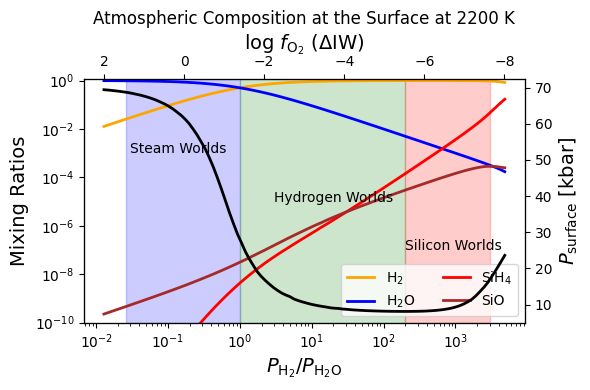

In [31]:
df = pd.read_csv(filename) 
ratio = df['H2'].values / df['H2O'].values
logfO2 = df['log_fO2_dIW'].values
H2 = df['H2'].values
H2O = df['H2O'].values
SiH4 = df['H4Si'].values
SiO = df['OSi'].values
O2 = df['O2'].values
tot = df['total_pressure'].values
fc = df['fugacity_coefficient'].values

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.set_ylim([1e-10,1.2])
ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax1a = ax1.twinx()
ax2 = ax1a.twiny()
ax2.invert_xaxis()
ax2.plot(logfO2, tot/1000, color='black', lw=2, label=r'$P_{\rm surface}$', zorder=0)

ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(ratio, H2/tot, color='orange', lw=2, label=r'H$_2$')
ax1.plot(ratio, H2O/tot, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(ratio, SiH4/tot, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(ratio, SiO/tot, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at 2200 K')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$P_{\rm H_2}/P_{\rm H_2O}$', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)
#ax2.set_ylim([0,1.1e2])

ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=2, loc='lower right')
plt.savefig("SiOH_nosolubility_ideal_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nosolubility_ideal_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### 4. H2/H2O ratio variation: H2O-H2-O2-SiO-SiH4-SiO2l system (non-ideal, no solubility) 

In [32]:
df = pd.read_csv(filename) 
df = df[['H2', 'H2O', 'O2', 'OSi', 'H4Si', 'SiO2']]
#df['H2'] = df['H2'] * adjust_sol(df['H2']) 
#df['H4Si'] = df['H4Si'] / adjust_sol(df['H2']) **2
insols = df.to_numpy()

surface_temperature = 2200 # K
massH_ocean = 200 # earth oceans
total_pressure = 100000 # bar

species = setup_species(flag_solubility = False, flag_nonideality = True)
planet = setup_planet(surface_temperature = surface_temperature, mantle_mass = 11*4.208261222595111e24, 
                      surface_radius = 1.7*6371000)

log_fO2_dIWs = np.linspace(-8, 2, num=100) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint = setup_constraints(
        flag_mass_constraint = True, # if True: MassConstraint(), else: TotalPressureConstraint()
        massH_ocean = massH_ocean, # mass of H equivalent to water oceans
        total_pressure = total_pressure, # bar
        logfO2_shift = log_fO2_dIW, # deltaIW = 0 by default
        )
    constraints.append(constraint)

system = setup_system(species, planet)
solutions = []

for (log_fO2_dIW, constraint, insol) in zip(log_fO2_dIWs, constraints, insols):

    solution = solve_system(system, constraint, factor=0.1, initial_solution=insol)
    fug_coeff = model1.fugacity_coefficient(temperature=surface_temperature, pressure=solution['total_pressure'])
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_nosolubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

[14:49:16 - atmodeller.core                - INFO     ] - Creating GasSpecies H2 using thermodynamic data in JANAF (JANAF name = H2)
[14:49:16 - atmodeller.core                - INFO     ] - Creating GasSpecies H2O using thermodynamic data in JANAF (JANAF name = H2O)
[14:49:16 - atmodeller.core                - INFO     ] - Creating GasSpecies O2 using thermodynamic data in JANAF (JANAF name = O2)
[14:49:16 - atmodeller.core                - INFO     ] - Creating GasSpecies OSi using thermodynamic data in JANAF (JANAF name = OSi)
[14:49:16 - atmodeller.core                - INFO     ] - Creating GasSpecies H4Si using thermodynamic data in JANAF (JANAF name = H4Si)
[14:49:16 - atmodeller.core                - INFO     ] - Creating LiquidSpecies SiO2 using thermodynamic data in JANAF (JANAF name = O2Si)
[14:49:16 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:49:16 - atmodeller.interior_atmosphere - INFO     ] - mantle_mass = 4.629087344854622e+25
[14:49:16 - a

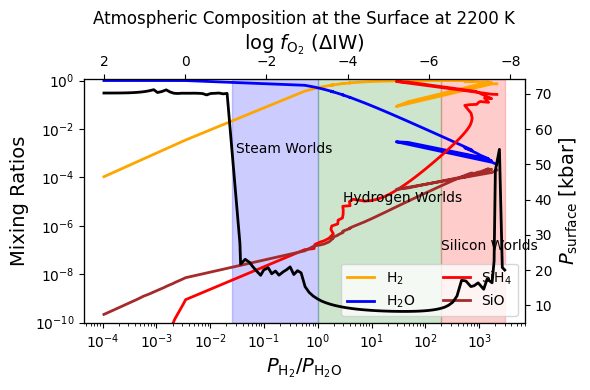

In [33]:
df = pd.read_csv(filename) 
ratio = df['H2'].values / df['H2O'].values
logfO2 = df['log_fO2_dIW'].values
H2 = df['H2'].values
H2O = df['H2O'].values
SiH4 = df['H4Si'].values
SiO = df['OSi'].values
O2 = df['O2'].values
tot = df['total_pressure'].values
fc = df['fugacity_coefficient'].values

fig, ax1 = plt.subplots(1, figsize=(6,4), tight_layout='True')

ax1.set_ylim([1e-10,1.2])
ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax1a = ax1.twinx()
ax2 = ax1a.twiny()
ax2.invert_xaxis()
ax2.plot(logfO2, tot/1000, color='black', lw=2, label=r'$P_{\rm surface}$', zorder=0)

ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(ratio, H2/tot, color='orange', lw=2, label=r'H$_2$')
ax1.plot(ratio, H2O/tot, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(ratio, SiH4/tot, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(ratio, SiO/tot, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at 2200 K')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$P_{\rm H_2}/P_{\rm H_2O}$', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=2, loc='lower right')
plt.savefig("SiOH_nosolubility_ideal_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nosolubility_ideal_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()